In [7]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.nn.functional import softmax
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive
import matplotlib.pyplot as plt

In [8]:
# Step 2: Mount Google Drive to access the fine-tuned model
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Step 3: Load the datasets
tweets_df = pd.read_csv('stock_tweets.csv')
stock_df = pd.read_csv('stock_yfinance_data.csv')

In [40]:
# Step 4: Filter for TSLA data
import re

# Dictionary to expand common financial abbreviations
finance_abbreviations = {
    "PT": "Price Target",
    "EPS": "Earnings Per Share",
    "QoQ": "Quarter over Quarter",
    "YoY": "Year over Year",
    "MoM": "Month over Month",
    "FY": "Fiscal Year",
    "P/E": "Price-to-Earnings Ratio",
    "EBITDA": "Earnings Before Interest, Taxes, Depreciation, and Amortization",
}
def clean_financial_tweet(text):
    if not isinstance(text, str):
        return text  # Skip if text is not a string

    # 1. Replace URLs with [URL]
    text = re.sub(r"http\S+|www\S+", "[URL]", text)

    # 2. Remove hashtags but keep words (e.g., "#Tesla" -> "Tesla")
    text = re.sub(r"#(\w+)", r"\1", text)

    # 3. Remove stock tickers (e.g., "$AAPL" -> "AAPL")
    text = re.sub(r"\$(\w+)", r"\1", text)

    # 4. Remove mentions (@User)
    text = re.sub(r"@\w+", "", text)

    # 5. Expand financial abbreviations
    for abbr, full_form in finance_abbreviations.items():
        text = re.sub(rf"\b{abbr}\b", full_form, text, flags=re.IGNORECASE)

    # 6. Normalize repeated punctuation (e.g., "!!!" -> "!")
    text = re.sub(r"([!?.,])\1+", r"\1", text)

    # 7. Convert to lowercase
    text = text.lower()

    # 8. Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # 9. Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text
tweets_df['Tweet'] = tweets_df['Tweet'].apply(clean_financial_tweet)
tweets_df = tweets_df[tweets_df['Stock Name'] == 'TSLA'].copy()
stock_df = stock_df[stock_df['Stock Name'] == 'TSLA'].copy()

In [42]:
# Step 5: Load the fine-tuned FinancialBERT model and tokenizer
model_path = '/content/drive/MyDrive/financialbert_finetuned_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
# Check for GPU availability and move the model to GPU (A100 if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to GPU
model.eval()  # Set the model to evaluation mode
print(f"Using device: {device}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB


In [43]:
# Step 6: Sentiment Analysis on Tweets with Batching
# Create a custom dataset for the tweets
class TweetDataset(Dataset):
    def __init__(self, tweets, tokenizer, max_length=128):
        self.tweets = tweets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        encoding = self.tokenizer(
            tweet,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {key: value.squeeze(0) for key, value in encoding.items()}

# Create a DataLoader for batching
batch_size = 32  # Suitable for A100 GPU with 40GB memory
tweet_dataset = TweetDataset(tweets_df['Tweet'].tolist(), tokenizer, max_length=128)
tweet_loader = DataLoader(tweet_dataset, batch_size=batch_size, shuffle=False)

# Process tweets in batches
sentiment_scores = []
for batch in tweet_loader:
    # Move batch to GPU
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        probs = outputs.logits.softmax(dim=1)
        batch_scores = torch.argmax(probs, dim=1).cpu().numpy()  # Move back to CPU for numpy conversion
        # Map to sentiment scores: 0 (bearish) -> -1, 1 (neutral) -> 0, 2 (bullish) -> 1
        sentiment_map = {0: -1, 1: 0, 2: 1}
        batch_scores = [sentiment_map[score] for score in batch_scores]
        sentiment_scores.extend(batch_scores)

# Add sentiment scores to the DataFrame
tweets_df['Sentiment'] = sentiment_scores

In [44]:
# Step 7: Aggregate sentiment by date
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date
daily_sentiment = tweets_df.groupby('Date')['Sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Avg_Sentiment']

In [45]:
# Step 8: Prepare the stock data
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df = stock_df.sort_values('Date')
# Create the target variable: 1 if next day's Adj Close increases, 0 otherwise
stock_df['Next_Day_Trend'] = (stock_df['Adj Close'].shift(-1) > stock_df['Adj Close']).astype(int)

In [46]:
# Step 9: Merge sentiment with stock data
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='left')
merged_df['Avg_Sentiment'] = merged_df['Avg_Sentiment'].fillna(0)  # Fill missing sentiment with neutral (0)

In [47]:
# Step 10: Prepare features and target for RandomForest
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Avg_Sentiment']
X = merged_df[features]
y = merged_df['Next_Day_Trend']

# Drop the last row since it has no next day to predict
X = X[:-1]
y = y[:-1]

In [48]:
# Step 11: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Step 12: Train the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
# Step 13: Make predictions and calculate accuracy
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the RandomForest model: {accuracy:.2f}")

Accuracy of the RandomForest model: 0.65


In [51]:
# Step 14: Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
         Feature  Importance
4         Volume    0.190970
5  Avg_Sentiment    0.175531
0           Open    0.169282
1           High    0.163610
3          Close    0.160538
2            Low    0.140069


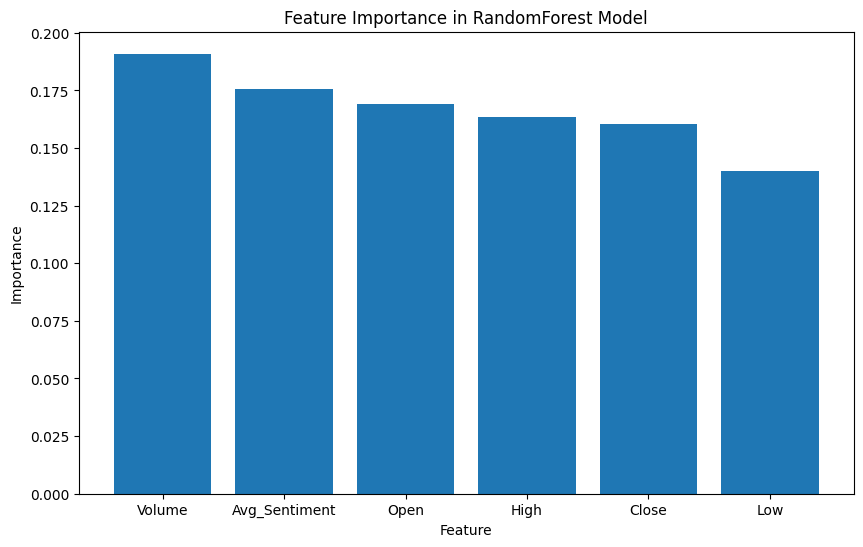

In [52]:
# Step 15: Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance in RandomForest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()